# MIRI/LRS Reduction

This notebook will walk you through the basics of data analysis for MIRI/LRS observations.

In [1]:
# First thing to do is set your CRDS variables so we can download the most up-to-date JWST 
# reference files. 

import os
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

Now let's get some data! exoTEDRF has a useful functionality which allows you to automatically grab any (public) data from the MAST archive.  
In keeping with the other tutorials, let's use some WASP-39b transit observations. But this time not from the JWST Transiting Exoplanet Community Early Release Science program, but from a followup DDT which was published in [Powell et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024Natur.626..979P/abstract).

In [ ]:
from exotedrf.extra_functions import download_observations

# We want all data associated with proposal ID 2783 for target WASP-39b. 

download_observations(proposal_id='2783', objectname='WASP-39b', instrument_name='MIRI/SLITLESS', 
                      filters='P750L')

# This will store all files in a folder in the present directory called DMS_uncal.

Now let's create output directories to store our data products.

In [2]:
from exotedrf import utils

# Generate output directories
utils.verify_path('pipeline_outputs_directory')
utils.verify_path('pipeline_outputs_directory/Stage1')
utils.verify_path('pipeline_outputs_directory/Stage2')
utils.verify_path('pipeline_outputs_directory/Stage3')
utils.verify_path('pipeline_outputs_directory/Stage4')

exoTEDRF is subdivided into four stages, mirroring the STScI jwst pipeline.  
The stages are as follows:
 - Stage 1: Detector Level Processing 
 - Stage 2: Spectroscopic Processing
 - Stage 3: 1D Spectral Extraction
 - Stage 4: Light Curve Fitting 
 
This notebook will walk you through stages 1 to 3, or from raw data to extracted stellar spectra. 

## Stage 1 -- Detector-Level Processing

Stage 1 performs multiple important calibrations on the raw, 4D (integrations, groups, y-pixel, x-pixel) data cubes. Several steps are simply wrappers around the existing functionalities of the STScI pipeline, whose documentation can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html).

In [3]:
from exotedrf import stage1

# First define some input and output directory paths.

uncal_indir = 'DMS_uncal/'  # Where our uncalibrated files are found. 
outdir_s1 = 'pipeline_outputs_directory/Stage1/'  # Where to save our Stage 1 output files.

Now let's make a list with all the uncal input files.  
In this case, the full TSO is broken up into nine segments.

In [4]:
filenames = [uncal_indir+'jw02783001001_04103_00001-seg001_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg002_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg003_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg004_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg005_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg006_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg007_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg008_mirimage_uncal.fits',
             uncal_indir+'jw02783001001_04103_00001-seg009_mirimage_uncal.fits']

Let's check the readout pattern of the observations. 

In [5]:
from astropy.io import fits

with fits.open(filenames[0]) as file:
    print('No. integrations: {}'.format(file[0].header['NINTS']))
    print('No. groups: {}'.format(file[0].header['NGROUPS']))
    print('subarray: {}'.format(file[0].header['SUBARRAY']))

No. integrations: 1779
No. groups: 100
subarray: SLITLESSPRISM


Here we can see that the full TSO consists of 1779 integrations, with 100 groups per integration using the slitlessprism mode (i.e., a 72 x 416 pixel subarray). 

Let's now take a look at what the raw data looks like.

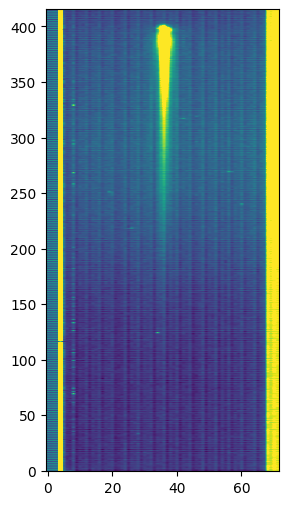

In [6]:
import matplotlib.pyplot as plt

with fits.open(filenames[0]) as file:
    plt.figure(figsize=(3, 6))
    # Let's check out the last group of the 10th integration
    plt.imshow(file[1].data[10, -1], aspect='auto', origin='lower', vmax=1e4)
    plt.show()

Unlike other modes, the MIRI detector is long and skinny, and the spectrum is dispersed in the vertical direction.  
Here we can clearly see the target spectral trace as well as a number of detector effects that we need to take care of.

Next, let's make sure that the observations were successful (i.e., we actually observed a transit).

2025-05-01 09:27:02.341 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg001_mirimage_uncal.fits.
2025-05-01 09:27:02.601 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg002_mirimage_uncal.fits.
2025-05-01 09:27:02.863 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg003_mirimage_uncal.fits.
2025-05-01 09:27:03.124 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg004_mirimage_uncal.fits.
2025-05-01 09:27:03.380 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg005_mirimage_uncal.fits.
2025-05-01 09:27:03.637 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg006_mirimage_uncal.fits.
2025-05-01 09:27:03.896 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg007_mirimage_uncal.fits.
2025-05-01 09:27:04.156 - exoTEDRF - INFO - Reading file DMS_uncal/jw02783001001_04103_00001-seg008_mirimage_uncal.fits.
2025-05-01 09:27:04.415 - exoTED

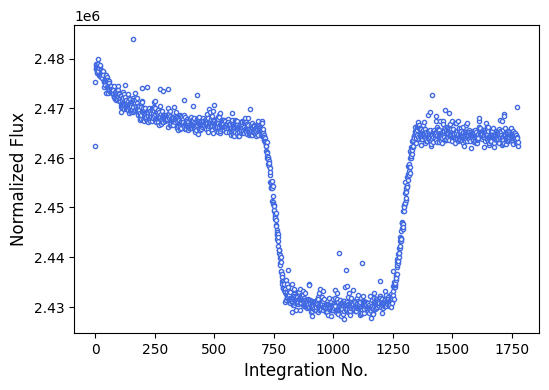

In [7]:
from exotedrf.plotting import plot_quicklook_lightcurve

# Make a quick a dirty light curve plot.
plot_quicklook_lightcurve(filenames)

Looks good! The transit is reasonably centered in the time series, and we can already see it clearly even in the raw data! Ingress appears to be around integration 750, and egress at 1300. Let's keep those values in mind to use later.  
We can also clearly see MIRI's infamous exponential ramp systematic at the start of the light curve. 

We're now ready to start with the actual reduction.

### DQ Initalization Step
Intializes the data quality flags and flags saturated pixels.  
Unlike other instrument modes, we also flag the first and last groups as DO_NOT_USE, since they are known to be ill-behaved. 

In [ ]:
# Initialize the step by passing the input files and the directory to which we want to save 
# the outputs. 
# There's also an option to pass a custom hot pixel map in order to identify and flag hot pixels 
# which are not already in the default data quality map. This should be a boolean map with True 
# values for hot pixels and False otherwise. A version of this is output by the BadPixStep towards 
# the end of Stage 2. 

step = stage1.DQInitStep(filenames, hot_pixel_map=None, output_dir=outdir_s1)

# Now run the step! 
# This step has options for diagnostic plotting. Specifying do_plot=True will create the step 
# plot and save it to the output directory.
# If you want to change the saturation threshold, you can do so by passing a value to the saturation_threshold keyword.
# If not, an instrument-dependent default value will be used.

results = step.run(save_results=True, force_redo=True, do_plot=True, show_plot=True)

In [ ]:
# Display the step plot.

from IPython.display import Image

Image(filename=outdir_s1 + 'dqinitstep.png') 

Here we can see a map of all saturated pixels in a frame of the observations. There are only a small handful -- mostly just due to known hot pixels. So nothing that really needs to be worried about!

### EMI Correction Step
As has been noted in several previous studies using MIRI (e.g., [Bell et al. 2024](https://ui.adsabs.harvard.edu/abs/2024NatAs...8..879B/abstract) and [Welbanks et al. 2024](https://ui.adsabs.harvard.edu/abs/2024Natur.630..836W/abstract)), the detectors are subject to row-correlated noise with a frequency of approximately 390Hz (as well as several higher-order harmonics). This step removes this noise. 

In [ ]:
# This time we pass the outputs from the previous step as the inputs for this step.

step = stage1.EmiCorrStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

### Reset Anomaly Correction Step
MIRI detectors are subject to a number of complications and additional noise sources due to the resetting of the detector (see the excellent discussion in [Morrison et al. 2024](https://ui.adsabs.harvard.edu/abs/2023PASP..135g5004M/abstract)). Broadly, these can be broken up into long, and short timescale effects, which, in large part, affect the linearity of the accumulated signal as more and more groups are taken up-the-ramp.  
This step nominally corrects the short-timescale "reset anomaly", however, currently the step is benign and does not do anything. This is due to the fact that the ResetStep reference file only contains zeros. In any case, we include it here for completeness, and maybe one day it will actually do something!

In [ ]:
# Currently doesn't do anything -- reference file is all zeros!
step = stage1.ResetStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

### Linearity Step
Here, we deal with many of the other non-ideal up-the-ramp behaviours of MIRI detectors due to the reset, as well as correct the usual non-linear behaviour of the detector (as with other JWST modes).  
In addition to the reset anomaly, MIRI detectors are also subject to the Reset Switch Charge Decay (RSCD) effect stemming from the detector reset. The RSCD signature takes much longer to fade out than the reset anomaly (see Figure 12 in [Morrison et al. 2024](https://ui.adsabs.harvard.edu/abs/2023PASP..135g5004M/abstract)). Currently, the RSCD effect is handled by flagging the first N groups up-the-ramp where the RSCD effects are worst. A self-calibration routine that would allow for the retention of all groups is curretly in development.  
After that, we proceed to correct the residual nonlinear effects using preset polynomials as we would in the JWST's other modes.  
Finally, whereas with the NIR modes on JWST we would use a separate step to correct the dark current, with MIRI, that is roped into the nonlinearity correction. This is because the dark signal also includes the effects of the reset anomaly and RSCD. The dark current is also more significant for MIRI than for the NIR modes, meaning that the correction is not optional.

In [ ]:
step = stage1.LinearityStep(results, output_dir=outdir_s1)

# We'll cut the first 12 groups here.

results = step.run(save_results=True, force_redo=True, do_plot=True, miri_drop_groups=12)

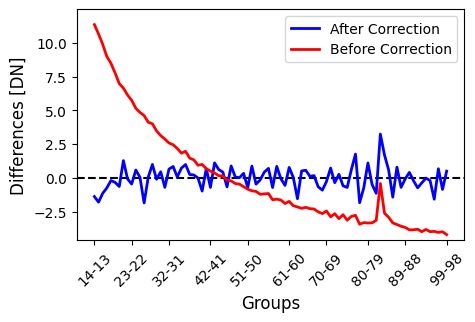

In [8]:
Image(filename=outdir_s1 + 'linearitystep_1.png') 

We can see that the group-to-group differences (which should yield a flat line in an ideal scenario) were exceptionally bad before the linearity correction. You will also see large residuals at easly group differences after the correction if you have not trimmed a sufficient number of groups at the beginning of each integration. It's important to play around with this parameter to find the best option for your particular observation.

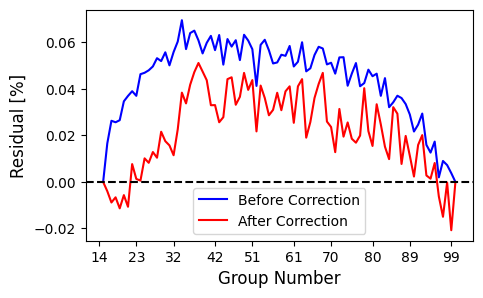

In [9]:
Image(filename=outdir_s1 + 'linearitystep_2.png') 

### Jump Detection Step
We now want to detect and flag cosmic ray hits in the data. There are two main ways to do this: up-the-ramp or time-domain flagging. 

The up-the-ramp flagging algorithm is the default algorithm in the STScI pipeline. In entails identifying discontinuities above a certain threshold in ramps, and flagging these as jumps. Unfortunately, this method can be quite temperamental and has been found by many studies to flag random noise. It also cannot be applied to ngroup=2 datasets.

The time-domain flagging method uses a sigma clipping algorithm to identify cosmic ray hits in the time domain. This method also has the benefit of working for observations with any number of groups. 

In [ ]:
step = stage1.JumpStep(results, output_dir=outdir_s1)

# Here we will use the time-domain rejection by specifying flag_in_time=True, and use a clipping 
# threshold of 7 sigma.
# In order to use the up-the-ramp flagging, specify instead flag_up_ramp=True and pass an 
# appropriate value to the rejection_threshold keyword. 

results = step.run(save_results=True, force_redo=True, flag_up_ramp=False, 
                   time_rejection_threshold=7, do_plot=True, flag_in_time=True)

The diagnostic plot here shows the locations of flagged jumps, as well as hot pixels in nine frames. 

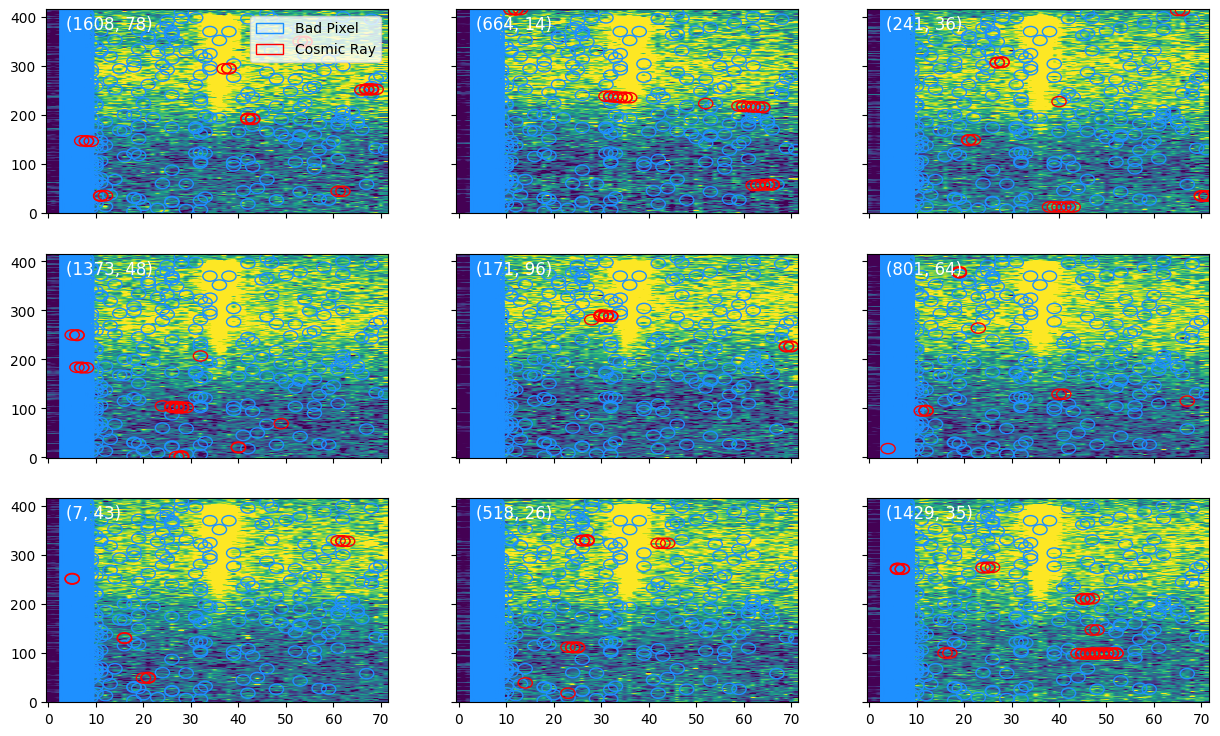

In [10]:
Image(filename=outdir_s1 + 'jump.png') 

### Ramp Fit Step
Now that all the initial detector-level calibrations are done, we are ready for ramp fitting! This step is a wrapper around the STScI pipeline step that fits a slope and intercept as a function of group to each pixel. We don't use the intercept values, and only care about the slopes moving forwards.

This step also produces outlier pixel masks by combining all existing data flags. One flag file is produced for each segment and is saved in the Stage 1 directory with the name XXX_pixelflags.fits.

In [ ]:
step = stage1.RampFitStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

### Gain Scale Step
The gain scale correction does the conversion from DN/s to e-/s by multiplying the data values by the wavelength dependent MIRI gain (3.1 e-/DN on average).  
Currently, though, this correction does nothing! But maybe it won’t sometime soon!

In [ ]:
step = stage1.GainScaleStep(results, output_dir=outdir_s1)

results = step.run(save_results=True, force_redo=True)

We are now ready to start with Stage 2!

## Stage 2 -- Spectroscopic Processing

This stage performs some additional calibrations on the, now 3D (integrations, y-pixel, x-pixel), data after the ramp fitting to make the data ready for the spectral extraction. Once again, information on the default STScI pipeline steps can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html).

In [11]:
from exotedrf import stage2

# Let's now save outputs to the Stage 2 subdirectory. 

outdir_s2 = 'pipeline_outputs_directory/Stage2/'

Since MIRI/LRS is a slitless mode, the Stage 2 calibrations are more similar to those of NIRISS/SOSS as opposed to NIRSpec modes. In particular, the determination of the wavelength solution is much less complicated as we don't have to worry about the effects of a slit!

### Assign WCS Step
This is mostly a wrapper around the STScI pipeline step which assigns the appropriate WCS to the data. 

In [ ]:
step = stage2.AssignWCSStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

### Source Type Determination Step
For multiple subsequent steps to function, we need to correctly identify the source type in our observations. For all exoplanet TSOs, the correct type is a point source.

In [ ]:
step = stage2.SourceTypeStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

### Flat Field Subtraction Step
This step corrects flat fielding effects.

In [ ]:
step = stage2.FlatFieldStep(results, output_dir=outdir_s2)

results = step.run(save_results=True, force_redo=True)

### Background Subtraction Step
Subtract the background.  
For MIRI observations, like NIRSpec and unlike SOSS, we can use the data itself to estimate the background contribution. Here, we'll do that using a row-wise median of non-illuminated pixels. 

In [ ]:
step = stage2.BackgroundStep(results, output_dir=outdir_s2, miri_method='median')

# We'll use a median of columns 12 -- 26 and 46 -- 60 to estimate the row-wise background contribution.
# The number of columns masked around the spectral trace is adjusted with the miri_trace_width parameter, 
# and the number of columns in each background region with miri_background_width.

results = step.run(save_results=True, force_redo=True, miri_trace_width=20, miri_background_width=14)[0]

### Bad Pixel Correction Step
We are now going to interpolate any remaining bad pixels in the data to be ready for the spectral extraction.  

The BadPixStep performs two iterations of bad pixel detection and correction: the first is a spatial correction, and the second a temporal one. 

The spatial correction uses a median stack of all integrations to identify any pixels which are systematic outliers across the entire time series. These pixels are flagged, and then interpolate using a median of the surrounding pixels in each integration. Any pixels with DQ flags are also interpolated in this way. It will also produce and save a map of these hot pixels which are not already in the default DQ flags. 

The temporal flagging works the same way as the time-domain jump detection, by flagging any pixels which are outliers along the time axis, and replacing them with a median of the surrounding pixels in time. 

In [ ]:
step = stage2.BadPixStep(results, baseline_ints=[-250], output_dir=outdir_s2)

# We're going to use a 10 sigma threshold for both the spatial and temporal corrections.

results = step.run(save_results=True, force_redo=True, do_plot=True, time_thresh=10)

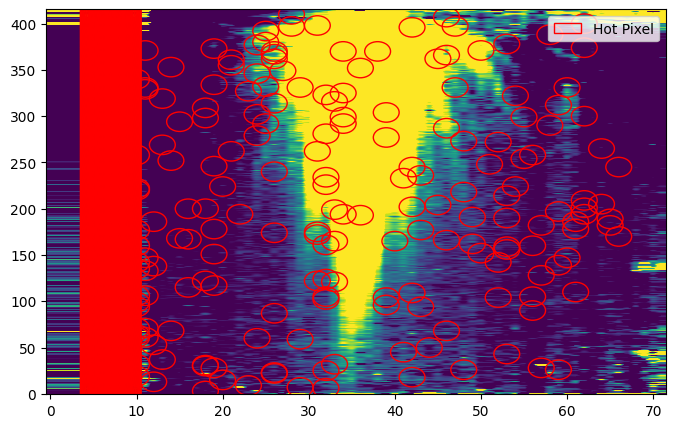

In [12]:
Image(filename=outdir_s2 + 'badpixstep.png') 

The diagnostic plot here shows the deep stack (median stack) with the locations of all hot and other flagged pixels.  
The large swath of red on the left side of the detector is the so-called "lightsaber artifact", and really isn't going to end up affecting our spectra. But we'll correct it anyways. 

### PCA Reconstruction Step

This is the penultimate step of Stage 2, and the final one that actually performs any true data calibrations before the extraction. 

The PCAReconstructStep uses principle component analysis (PCA) to deconstruct the timeseries into eigenimages that explain the largest amount of variance in the data, and their corresponding eigenvector timeseries. We then have the option to reconstruct the data, removing the components which correspond to detector "noise" (e.g., trace position drifts, tilt events, etc.). 

The first integration of MIRI observations is known to often be ill-behaved. We're going to clip it by replacing it with the subsequent integration. The TSO has >1700 integartions, so clipping one isn't an issue. 

In [ ]:
# Replace the first integration.

seg001 = fits.open(results[0])
seg001[1].data[0] = seg001[1].data[1]
seg001.writeto(results[0], overwrite=True)

Now proceed with the step.

In [ ]:
step = stage2.PCAReconstructStep(results, baseline_ints=[-250], output_dir=outdir_s2)

# We're going to show the first 10 PCA components.

results, deepframe = step.run(save_results=True, force_redo=True, do_plot=True, pca_components=10, 
                              remove_components=[3])

The first diagnostic plot is the intial results of the PCA. Here we see the eigenimages (right) and eigenvalue timeseries (left) of the 10 components that explain the most variance in the data. 

There is ALOT going on in this plot! The first component is the transit white light curve itself. The second really correlates with the detector -- namely in the eigenimage we see the central pixel highlighted and the edge pixels of the trace in darker colours. This is likely due to residual nonlinearity (and/or charge migration), whereby the brightest pixels in the trace see a slightly different transt depth than the edge pixels. This kind of shows up in the eigenvalue time series where you can see a slight bump anti-correlated with the transit. There is also a clear exponential systematic. You can choose to remove this from the data, though I often find it actually makes the exponential ramp worse instead of better without having much of an effect on the noise properties.  

The next component, is also correlated with the detector -- probably a slight horizontal shift. We'll remove this one from the data.

Beyond that, there is still a substatial amount of substructure in the other eigenvalue timeseries, but mostly in regions of the detector that we are not going to extract. So we'll leave them just to be conservative. 

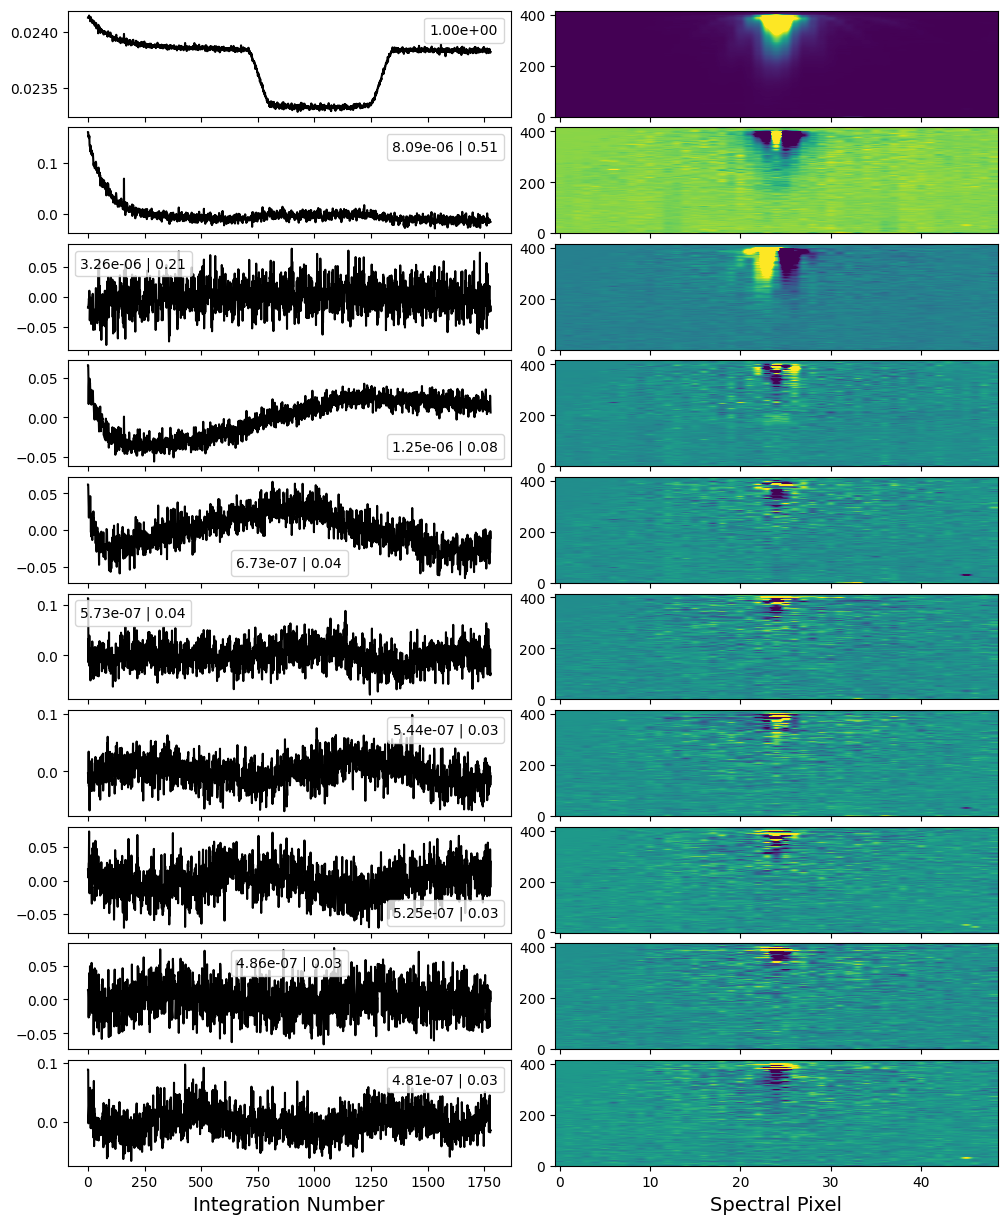

In [13]:
Image(filename=outdir_s2 + 'stability_pca.png') 

The second diagnostic plot shows the PCA results after the data reconstruction. We now see that the eigenimage that we wanted to remove is no longer present!

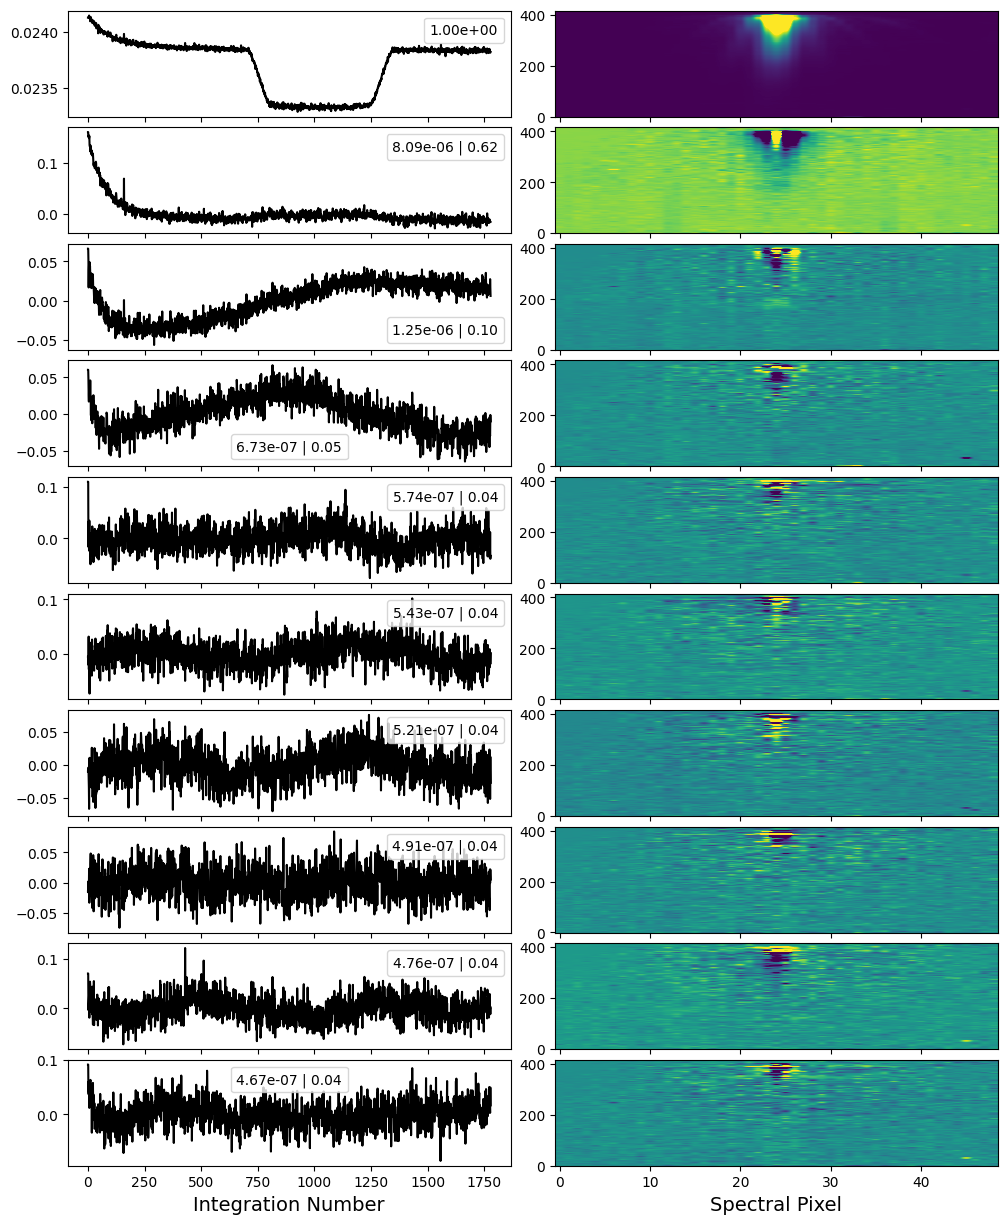

In [14]:
Image(filename=outdir_s2 + 'stability_pca_reconstructed.png') 

A good plan of attack is to run this step first, passing ```remove_components=None``` to see the initial results. In this case, the step will simply return the input data with no reconstruction. You can then re run the step specifying the components that you identified as detector-related noise and want to remove. 

<div class="alert alert-block alert-info"> <b>WARNING:</b> Its important to be careful with the number of components being removed. Just like with high resolution cross correlation spectroscopy, removing components *can* have an effect on the final atmosphere spectrum. Only remove things that you *know* are detector correlated (positional drifts, beating patterns, etc.). If in doubt, compare your level of light curve scatter as well as the end atmosphere spectrum itself with and without the PCA removal. 
</div>

### Tracing Step
This step does not do any actual data calibration, but produces a number of auxiliarly files which may be useful either for improving the reduction, or in the subsequent light curve analysis. 

For MIRI observations, it's major functionality is to locate the centroids of the MIRI spectral trace via the [edgetrigger algorithm](https://ui.adsabs.harvard.edu/abs/2022PASP..134j4502R/abstract).   

In [ ]:
step = stage2.TracingStep(results, deepframe=deepframe, output_dir=outdir_s2)

centroids = step.run(save_results=True, force_redo=True, do_plot=True)

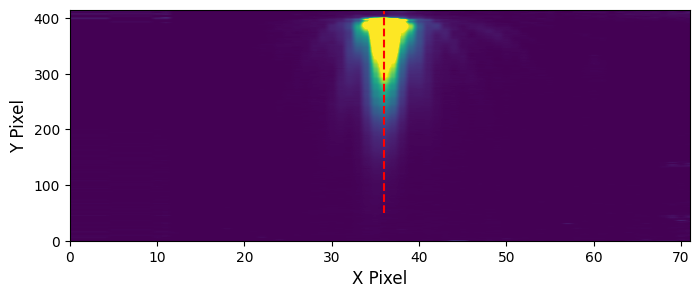

In [15]:
Image(filename=outdir_s2 + 'centroiding.png') 

The diagnostic plot here shows the results of the trace centroiding.

Now one more thing before moving on to the extraction. Let's take a look at the deep stack and double check our trace positions.

In [16]:
# Read in the trace positions.

import pandas as pd

centroids = pd.read_csv(outdir_s2 + 'jw02783001001_04103_00001_mirimage_centroids.csv', comment='#')

In [18]:
# Read in the deepframe.

deepframe = fits.getdata(deepframe)

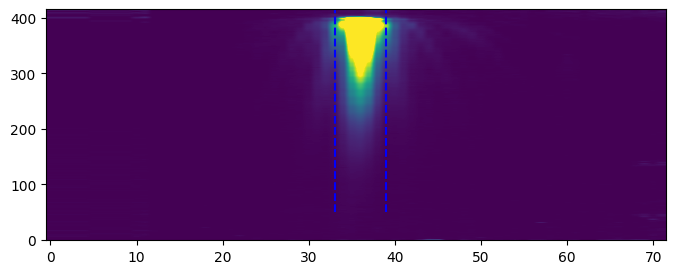

In [19]:
# Display the deepframe and the trace positions.

plt.figure(figsize=(8, 3))
plt.imshow(deepframe, aspect='auto', origin='lower', vmin=0, vmax=200)

# Show a width of 6 pixels around the trace.
plt.plot(centroids['xpos']+3, centroids['ypos'], ls='--', c='blue')
plt.plot(centroids['xpos']-3, centroids['ypos'], ls='--', c='blue')

plt.show()

Everything looks good! We're now ready for Stage 3 and the spectral extraction.

## Stage 3 -- 1D Spectral Extraction

This is the shortest stage, as it just performs the 1D spectral extraction. 

In [20]:
from exotedrf import stage3

# Let's now save outputs to the Stage 3 subdirectory. 

outdir_s3 = 'pipeline_outputs_directory/Stage3/'

WebbPSF not installed. Profile simulation not available.


For MIRI observations, exoTEDRF performs a simple aperture extraction. An optimal extraction routine is in development.

In [ ]:
step = stage3.Extract1DStep(results, extract_method='box', output_dir=outdir_s3)

# Here, we're using an aperture width of 6 pixels. 
# We also pass the trace positions from above.

results = step.run(extract_width=6, centroids=centroids, save_results=True, force_redo=True)

*Tada!* You now have stellar spectra of WASP-39! Let's take a quick look at the wavelength-dependent light curves.

In [21]:
import numpy as np

# Open the extracted spectrum file and get the relevant quantities.

file = fits.open(outdir_s3 + 'WASP-39_box_spectra_fullres.fits')
    
wave = file[1].data  # Wavelengths    
spec = file[3].data  # Spectra
t = file[5].data
    
base = -1-np.arange(200).astype(int)  # Baseline integrations
    
# Normalize the extracted spectra.  

spec_norm = spec / np.nanmedian(spec[base], axis=0)

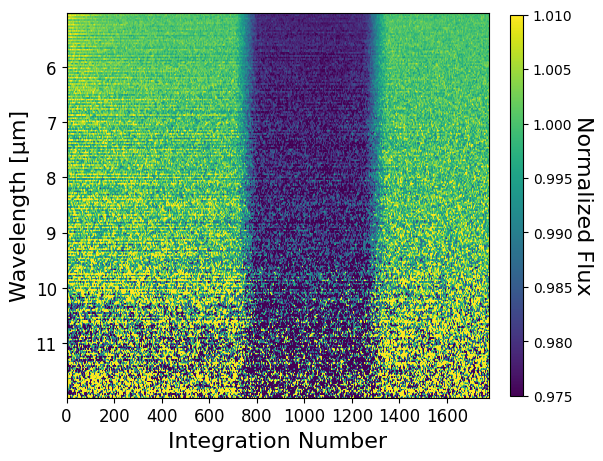

In [22]:
from exotedrf.plotting import make_2d_lightcurve_plot

# Technically, wavelengths from 4.5 -- ~14µm are extracted, however the instrument is only well calibrated 
# from 5 -- 12 µm.

ii = np.where((wave > 5) & (wave <= 12))[0]

# Display the light curves.

kwargs = {'vmin': 0.975, 'vmax': 1.01}
make_2d_lightcurve_plot(wave[ii], spec_norm[:, ii], instrument='MIRI', **kwargs)

Great! The bluer wavelengths look super clean, and we can clearly see the increase in noise at the redder wavelengths. This is unavoidable since the MIRI throughput drops off really rapidly towards 12µm.  
You may also notice that the ramp at the beginning of the timeseries seems to reverse direction between 10 and 11µm (i.e., the initial integrations are blue instead of yellow as elsewhere). This is the mysterious "shadowed region" of the detector, and it's unclear exactly why it causes the polarity of the ramp to change (see e.g., [Bell et al. 2024](https://ui.adsabs.harvard.edu/abs/2024NatAs...8..879B/abstract) for more discussion of the shadowed region). However, it can be dealt with straightforwardly enough in the light curve fitting.

exoTEDRF Stages 1 to 3 can also be run in script form via the provided run_DMS.py file. Simply fill out the corresponding yaml file with all relevant inputs, and you’re good to go! Generally, I like to take a first pass at the data in a notebook, where I can double check the outputs of each step, and perhaps dig a bit deeper into some interesting things that pop up. I’ll then use the script for the second pass.

You’re now ready to fit some light curves and get your atmosphere spectrum, which is what you really want in the end, isn’t it?!